In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [5]:
df = pd.read_csv('./data/dataset_germanic.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
32859,eyes right away eyes right away eyes right away,English
20523,meinung waren dass meinung waren dass meinung,German
19012,arbeitsform durch arbeitsform durch,German
76845,gick det ock gick det ock gick det ock gick det,Swedish
21638,gestaltend einzuwirken auf gestaltend,German


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [6]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Input dimension: 50
Rows: 86454
Amount of languages to identify: 6


In [90]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
tf.keras.layers.SimpleRNN(8, activation='relu')
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [91]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, batch_size=2048,verbose=1)

Epoch 1/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.1736 - loss: 2.1639 - val_accuracy: 0.2180 - val_loss: 1.7795
Epoch 2/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.2250 - loss: 1.7709 - val_accuracy: 0.2652 - val_loss: 1.7293
Epoch 3/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.2643 - loss: 1.7241 - val_accuracy: 0.2984 - val_loss: 1.6859
Epoch 4/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.2936 - loss: 1.6882 - val_accuracy: 0.3270 - val_loss: 1.6370
Epoch 5/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.3214 - loss: 1.6430 - val_accuracy: 0.3591 - val_loss: 1.5808
Epoch 6/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.3539 - loss: 1.5813 - val_accuracy: 0.3905 - val_loss: 1.5231
Epoch 7/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.3879 - loss: 1.5221 - val_accuracy: 0.4119 - val_loss: 1.4705
Epoch 8/75
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 176ms/step - accuracy: 0.4088 - loss: 1.4758 - val_accuracy: 0.

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

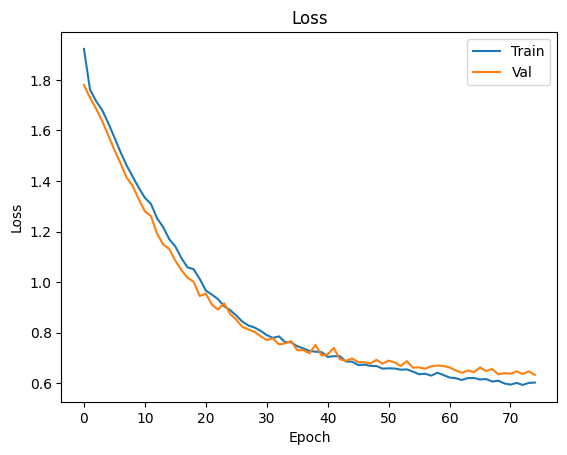

In [97]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

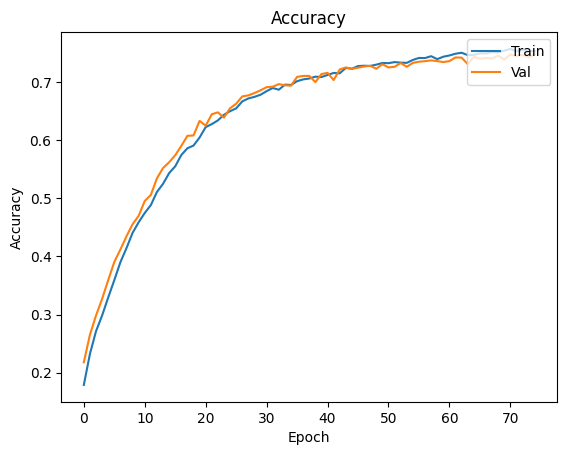

In [93]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [12]:
prediction_word = "jeg ved ikke hvad jeg skal lave i dag da jeg er"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: jeg ved ikke hvad jeg skal lave i dag da jeg er
Text after preprocessing: jeg ved ikke hvad jeg skal lave i dag da jeg er
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Language_Danish: 51.4
Language_Dutch: 0.0
Language_English: 0.1
Language_German: 0.0
Language_Norwegian: 45.6
Language_Swedish: 2.9


# Save model
Here a model can be loaded

In [95]:
model.save('./models/model_germanic.keras')

# Load model
Here a model can be loaded

In [11]:
model = load_model('./models/model_germanic.keras')